## Importing area

In [1]:
import civil_war_base as cw
import pandas as pd
import timeit
from itertools import compress
from country_converter import CountryConverter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.stats as sp
from datetime import timedelta  
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# Forecasting civil wars
The aim of this project is to determine the causes that start a civil war to make predictions to avoid future conflicts. It will use monthly aggregations of events to predict the starting, ongoingness and ending of a conflict for the next month. Although most studies focus on theory, this project’s approach will follow recent studies using event data.

A python file called **"civil_war_base.py"** was created. It contains all the functions used in this notebook. For more information about the functions, please look them up in this file since they all contain docstrings with information. 

# 1. About the data

## 1.1. Integrated Crisis Early Warning System 
The Integrated Crisis Early Warning System ([ICEWS](https://en.wikipedia.org/wiki/Integrated_Conflict_Early_Warning_System))is a repository that contains counts of daily events worldwide. The data is currently stored in the [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/28075) along with information about its content. This project uses version 29.0, with events from 1995 to April 2020. All the files are provided in the file **events.zip** in the same repository as this notebook. The file was uploaded using [Git Large File Storage](https://git-lfs.github.com/) due to its size. 

The ICEWS dataset records the "who did what to whom and where" for events across the globe. 

To simplify the description of the data, the year 2017 is used in the following. 

In [2]:
year_2017 = cw.read_events_year("events.zip",2017)
year_2017.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude
318342,27689106,6/9/2017,Mark McGowan,"Dissident,Protestors / Popular Opposition / Mobs",Australia,Accuse,112,-2.0,Australia,NaN,Australia,44501923.0,2.0,Unknown,Bellerive,Clarence,State of Tasmania,Australia,-42.8667,NaN
610903,28194571,11/3/2017,Giorgi Kvirikashvili,"Elite,Executive,Executive Office,Government",Georgia,Praise or endorse,51,3.4,Kersti Kaljulaid,"Executive,Elite,Government,Executive Office",Estonia,45729022.0,5.0,Prime-News (Georgia),Tbilisi,NaN,K'alak'i T'bilisi,Georgia,41.6941,NaN
339896,27727195,6/19/2017,Iran,NaN,Iran,fight with artillery and tanks,194,-10.0,Islamic State of Iraq and the Levant,"Muslim,Ideological,Dissident,Fundamentalist,In...",Iraq,44592044.0,3.0,Daily Star,Moscow,NaN,Moskva,Russian Federation,NaN,37.6156
85220,25487734,2/18/2017,Other Authorities / Officials (Pakistan),Government,Pakistan,Accuse,112,-2.0,Afghanistan,NaN,Afghanistan,43519469.0,6.0,EFE News Service,Qalandar,NaN,Ghor,Afghanistan,NaN,64.8029
423584,27870158,7/30/2017,Leopoldo LÃ³pez,"Centrist,(National) Minor Party,Parties,Dissid...",Venezuela,Make an appeal or request,20,3.0,Citizen (Venezuela),"General Population / Civilian / Social,Social",Venezuela,44933157.0,2.0,Agence France-Presse,NaN,NaN,NaN,Venezuela,10.5000,NaN


The table above shows some rows from the 2017 ICEWS dataset. 

### 1.1.1. Conflict and Mediation Event Observations
The Conflict and Mediation Event Observations code (CAMEO code) is a coding system for event data.  There are 20 different codes for 20 different types of events and each has different levels of subcoding. The document containing information about each code can be downloaded from the [Harvard Dataverse](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/28075/SCJPXX&version=30.0) too. 

### 1.1.2. Intensity 
The intensity value derives from teh CAMEO code. It ranges from -10 to 10, with -10 representing the most hostile events and 10 the most cooperative events. 

### 1.1.3. Cleaning the data
For the purpose of this project, it is necessary to clean the data. The cleaning process goes like this:

   **1. Select events where "Source Country" is the same as "Target Country"**: To consider only internal events that may suggest internal conflict. 
   
   A column named "Year_Month" was added to store the year and the month of the event. 

In [3]:
year_2017_internal = cw.internal_events_year("events.zip",2017)
year_2017_internal.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
441573,27901028,2017-08-08,Police (Belgium),"Government,Police",Belgium,"Arrest, detain, or charge with legal action",173,-5.0,Men (Belgium),"Social,General Population / Civilian / Social",...,45010464.0,1.0,Agence France-Presse,Brussels,(Bruxelles-Capitale),Bruxelles-Capitale,Belgium,NaN,4.34878,2017-08
560880,28109434,2017-10-09,Iyad Allawi,"Ideological,(National) Minor Party,Shia,Far Le...",Iraq,Make statement,10,0.0,Iraq,NaN,...,45519549.0,5.0,Associated Press Newswires,Kirkuk,NaN,Muhafazat Kirkuk,Iraq,NaN,44.39220,2017-10
45557,25413769,2017-01-29,Lawyer/Attorney (Australia),"Legal,Social",Australia,Criticize or denounce,111,-2.0,Australia,NaN,...,43340007.0,1.0,The Courier-Mail,Palm Island,NaN,State of Queensland,Australia,-18.7356,146.57800,2017-01
226985,27531913,2017-04-28,Manish Sisodia,"Far Left,(National) Major Party,Parties,Govern...",India,Demand,100,-5.0,Government (India),Government,...,44129152.0,3.0,The Times of India,Delhi,NaN,National Capital Territory of Delhi,India,28.6538,77.22900,2017-04
237287,27550177,2017-05-04,Alhaji Lai Mohammed,"Social,Media,Parties,(National) Major Party,(N...",Nigeria,Reject,120,-4.0,Media Personnel (Nigeria),"Social,Media",...,44171576.0,3.0,Unknown,Abuja,NaN,Federal Capital Territory,Nigeria,NaN,7.49508,2017-05


**2. Simply sectors mapping them**: Four sectors will be considered: Government (Gov), Insurgents (Ins), Opposition (Opp) and People (Peo). This will simplify the model and improve its interpretability. 

To map "Source/Target Name/Sectors" column a list of possible descriptions for each sector was used.  If the name of the country was in any of the "Source/Target Name/Sectors" columns, the sector was identified as Government.

In [4]:
year_2017_filtered = cw.read_filtered_data("events.zip",2017)
year_2017_filtered.sample(5)

,Event ID,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,...,Story ID,Sentence Number,Publisher,City,District,Province,Country,Latitude,Longitude,Year_Month
575942,28135083,2017-10-16,Media (India),Peo,India,Consult,40,1.0,Ministry (India),Gov,...,45584032.0,2.0,The Hindu,New Delhi,NaN,National Capital Territory of Delhi,India,NaN,77.2244,2017-10
191894,27470539,2017-04-12,Military (Philippines),Gov,Philippines,Praise or endorse,51,3.4,Other Authorities / Officials (Philippines),Gov,...,43982333.0,4.0,Vietnam News Agency Bulletin,Bohol,Province of Leyte,Eastern Visayas,Philippines,11.6803,NaN,2017-04
444933,27906757,2017-08-10,India,Gov,India,"Arrest, detain, or charge with legal action",173,-5.0,Citizen (India),Peo,...,45025560.0,2.0,Agence France-Presse,New Delhi,NaN,National Capital Territory of Delhi,India,NaN,77.2244,2017-08
253916,27579032,2017-05-11,Militant (India),Ins,India,Make an appeal or request,20,3.0,Military Personnel (India),Gov,...,44241736.0,6.0,The Hindu,Kulgam,NaN,State of Jammu and Kashmir,India,NaN,75.0187,2017-05
308451,27672544,2017-06-05,Public Service Ministry/Department (Canada),Gov,Canada,Make statement,10,0.0,Government (Canada),Gov,...,44465498.0,1.0,Canada NewsWire,Dieppe,NaN,New Brunswick,Canada,46.0784,NaN,2017-06


**3. Remove irrelevant columns**: Only "Country", "Source Sectors" (renamed as "Source"), "CAMEO", "Intensity", "Target Sector" (renamed as "Target") and "Year_Month" will be considered. 

In [5]:
year_2017_cols = cw.read_cols_filtered("events.zip",2017)
year_2017_cols.sample(5)

,Country,Source,CAMEO,Intensity,Target,Year_Month
347064,Azerbaijan,Ins,180,-9.0,Gov,2017-06
77402,Syria,Ins,874,10.0,Gov,2017-02
705688,North Korea,Peo,10,0.0,Gov,2017-12
74640,Croatia,Gov,13,0.4,Peo,2017-02
422895,Germany,Ins,193,-10.0,Gov,2017-07


**4. Dummy variables of interaction**: A column for each Source_Target interaction will be generated (Gov_Opp, Peo_Ins, Ins_Gov,...) containing 1 if the event happens between the column sectors and 0 if not.  

This dummy encoding of the interaction will be helpful when building the models, when aggregating by “Year_Month” and “Country”, allowing means and counts of each type of interaction.

In [6]:
year_2017_final = cw.source_target_interaction("events.zip",2017)
year_2017_final.sample(5)

,Country,CAMEO,Intensity,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
94722,Myanmar,36,4.0,2017-02,0,0,0,0,0,0,0,0,1,0,0,0
705990,Spain,20,3.0,2017-12,0,0,1,0,0,0,0,0,0,0,0,0
321671,Mexico,10,0.0,2017-06,1,0,0,0,0,0,0,0,0,0,0,0
607939,Nepal,20,3.0,2017-11,0,0,1,0,0,0,0,0,0,0,0,0
24605,Turkey,180,-9.0,2017-01,0,0,0,0,0,1,0,0,0,0,0,0


**5. Adding ISO3 country code**: To avoid double counting a country (for example, North Korea and Republic of Korea) the ISO3 country code will be added. 

In [7]:
year_2017_iso3 = cw.iso3country("events.zip",2017)
year_2017_iso3.sample(5)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
350568,China,CHN,2017-06,20,3.0,0,0,1,0,0,0,0,0,0,0,0,0
535815,Lithuania,LTU,2017-09,51,3.4,0,0,0,0,0,0,0,0,0,1,0,0
333436,India,IND,2017-06,190,-10.0,0,0,1,0,0,0,0,0,0,0,0,0
696473,India,IND,2017-12,173,-5.0,0,0,1,0,0,0,0,0,0,0,0,0
51353,Iran,IRN,2017-02,17,0.0,0,0,1,0,0,0,0,0,0,0,0,0


To see all events considered, a file called "all_events.csv" was created:

As a final note, only about 25% of the original data was used for the models:

In [8]:
len(year_2017_iso3)/len(year_2017)

0.2554110833678221

# 1.2. Political Instability Task Force

The State Failure Problem dataset will be used to stablish the start and ending of a civil war. This dataset comes from the Political Instability Task Force ([PITF](https://en.wikipedia.org/wiki/Political_Instability_Task_Force)), which is an American project that focuses on collecting data of political conflicts and state failure. The dataset can be found on the Center of Systemic Peace [webiste](http://www.systemicpeace.org/inscrdata.html) as the [Cosolidated Cases](http://www.systemicpeace.org/inscr/PITF%20Consolidated%20Case%20List%202018.pdf) dataset. The PITF criteria to determine a civil war can be found in its [Codebook](http://www.systemicpeace.org/inscr/PITFProbSetCodebook2018.pdf). This dataset containg civil wars from 1955 to 2018. 

## 1.2.1. Cleaning the data
The original data is presented in a PDF an was converted to a **.xlsx** using a [PDF to Excel Converter](https://smallpdf.com/pdf-to-excel). The returned file contains errors. A function that reads and fixes the data was defined <code>read_PITF()</code>:

In [9]:
PITF = cw.read_PITF("PITF Consolidated Case List 2018-converted.xlsx")
PITF.sample(5)

,ISO3,Year_Month_S,Year_Month_F
101,MLI,1990-06,1995-01
57,ETH,2007-01,2018-12
144,SDN,1983-07,2018-12
27,TCD,2005-10,2010-04
7,ARM,1995-07,1996-09


# 2. Data analysis and model building
Since the project is using monthly aggregations of events, the target variable will be a categorical one, with 4 categories: 000 (No civil war), 001 (Civil war ongoing), 010 (Civil war ending) and 100 (Civil war starting). This encoding will allow to see differences between cases more easier. For each row, the code will represent what will happen in the next month. 

Some countries do not register events for certain months. In that case, the values for each column in the missing "Year_Month" value will be filled with 0s.

To determine those difference, t-tests will be applied between cases where no civil war is taking place (000) and cases were a civil war is starting (100). This will allow to see if there is any particular difference between cases. For ongoingness (001) and ending (010) of the civil war, t-test will be used to determine differences between those cases. Statistical significance will be considered for any p-value bellow 0.05. Values bellow 0.1 will also be studied, although not considered statistically significant. 

Principal component analysis will be applied on each model to look at data distributions and to see how well the model separates the data between cases. 

Finally, data will be modeled with random forests. Random forests are chosen as model because they can handle outliers and noise better than the other models. They are also good at reducing overfitting, which is ideal for the imbalanced data of this project. To meassure the model performance, the area under the receiving operating characteristic curve score (ROC AUC score) for each class will be used. 

One important thing to notice is the difference in the amount of data for each month between 1995 and 2018:

In [10]:
all_events = pd.read_csv("all_events.csv", low_memory = False)
all_events["Year_Month"] = pd.to_datetime(all_events["Year_Month"])

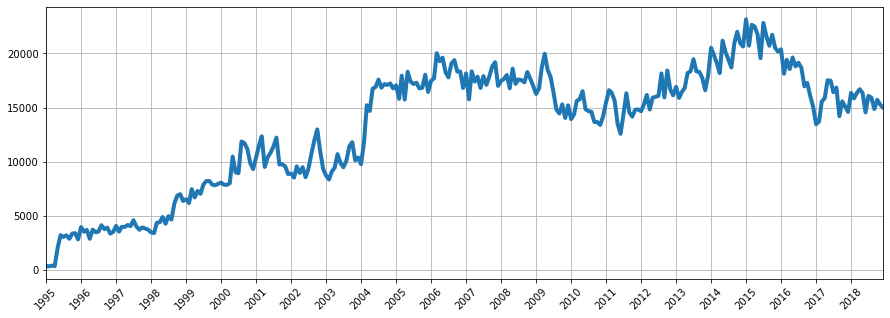

In [11]:
fig, ax = plt.subplots(figsize = (15,5))
ax.plot(all_events["Year_Month"].value_counts().sort_index(), linewidth=4)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.grid()
plt.xticks(rotation=45);
plt.autoscale(enable=True, axis='x', tight=True)
plt.rcParams.update({'font.size': 22})

The ammount of data in each month varies during time. Models that rely on counts can not be used, since this differences may bias the results. Relative (fraction of the total) or average models will be used to avoid this. 

For training porpuses, the model will be trained from 2004 onwards, and the rest of the data will be used as a test set. Validation will be performed using out of bag samples. 

## 2.1. Interaction fraction model
The interaction fraction model records the fraction of the total interactions that occured for each interaction pair. For example, looking at data from 2017:

In [12]:
year_2017_iso3.drop(["Country","Intensity"], axis = 1).groupby(["ISO3","Year_Month"]).sum().head(1)

,,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
ISO3,Year_Month,,,,,,,,,,,,
AFG,2017-01,71.0,3.0,59.0,81.0,1.0,54.0,6.0,1.0,2.0,42.0,16.0,2.0


Each column represents the total number of events where each pair of sectors took part. The country is Afghanistan, January 2017. That month 338 internal events were registered. The fraction of events for each interaction pair is the number of events registered for that pair divided by the total number of events:

In [13]:
year_2017_iso3.drop(["Country","Intensity"], axis=1).groupby(["ISO3","Year_Month"]).sum().head(1)/338

,,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
ISO3,Year_Month,,,,,,,,,,,,
AFG,2017-01,0.210059,0.008876,0.174556,0.239645,0.002959,0.159763,0.017751,0.002959,0.005917,0.12426,0.047337,0.005917


This way all values are between 0 and 1 and countries were less events are registered do not bias the model. 

The model is generated using the function <code>interaction_fraction</code>, since it takes way too long to run, it has already been saved as a *.csv* file. 

In [14]:
interaction_fraction = pd.read_csv("interaction_fraction_model.csv", converters = {"CW_plus1" : str})
interaction_fraction = interaction_fraction.drop("Unnamed: 0", axis = 1)
interaction_fraction["Year_Month"] = pd.to_datetime(interaction_fraction["Year_Month"]).dt.to_period('M')

In [15]:
interaction_fraction.sample(5)

,ISO3,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,...,Peo_Gov,Peo_Ins,Peo_Opp,CW_s,CW_f,CW_o,CW_s_plus1,CW_f_plus1,CW_o_plus1,CW_plus1
26236,HKG,1997-05,0.050000,0.150000,0.200000,0.000000,0.0,0.0,0.050000,0.05,...,0.350000,0.05,0.05,0.0,0.0,0.0,0,0,0,000
10122,CCK,1998-07,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,...,0.000000,0.00,0.00,0.0,0.0,0.0,0,0,0,000
15673,DEU,2005-02,0.096774,0.086022,0.344086,0.010753,0.0,0.0,0.096774,0.00,...,0.344086,0.00,0.00,0.0,0.0,0.0,0,0,0,000
10706,CHL,1999-03,0.000000,0.083333,0.250000,0.000000,0.0,0.0,0.250000,0.00,...,0.416667,0.00,0.00,0.0,0.0,0.0,0,0,0,000
35390,LCA,2016-03,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00,...,0.000000,0.00,0.00,0.0,0.0,0.0,0,0,0,000


The predcitors have the following distributions:

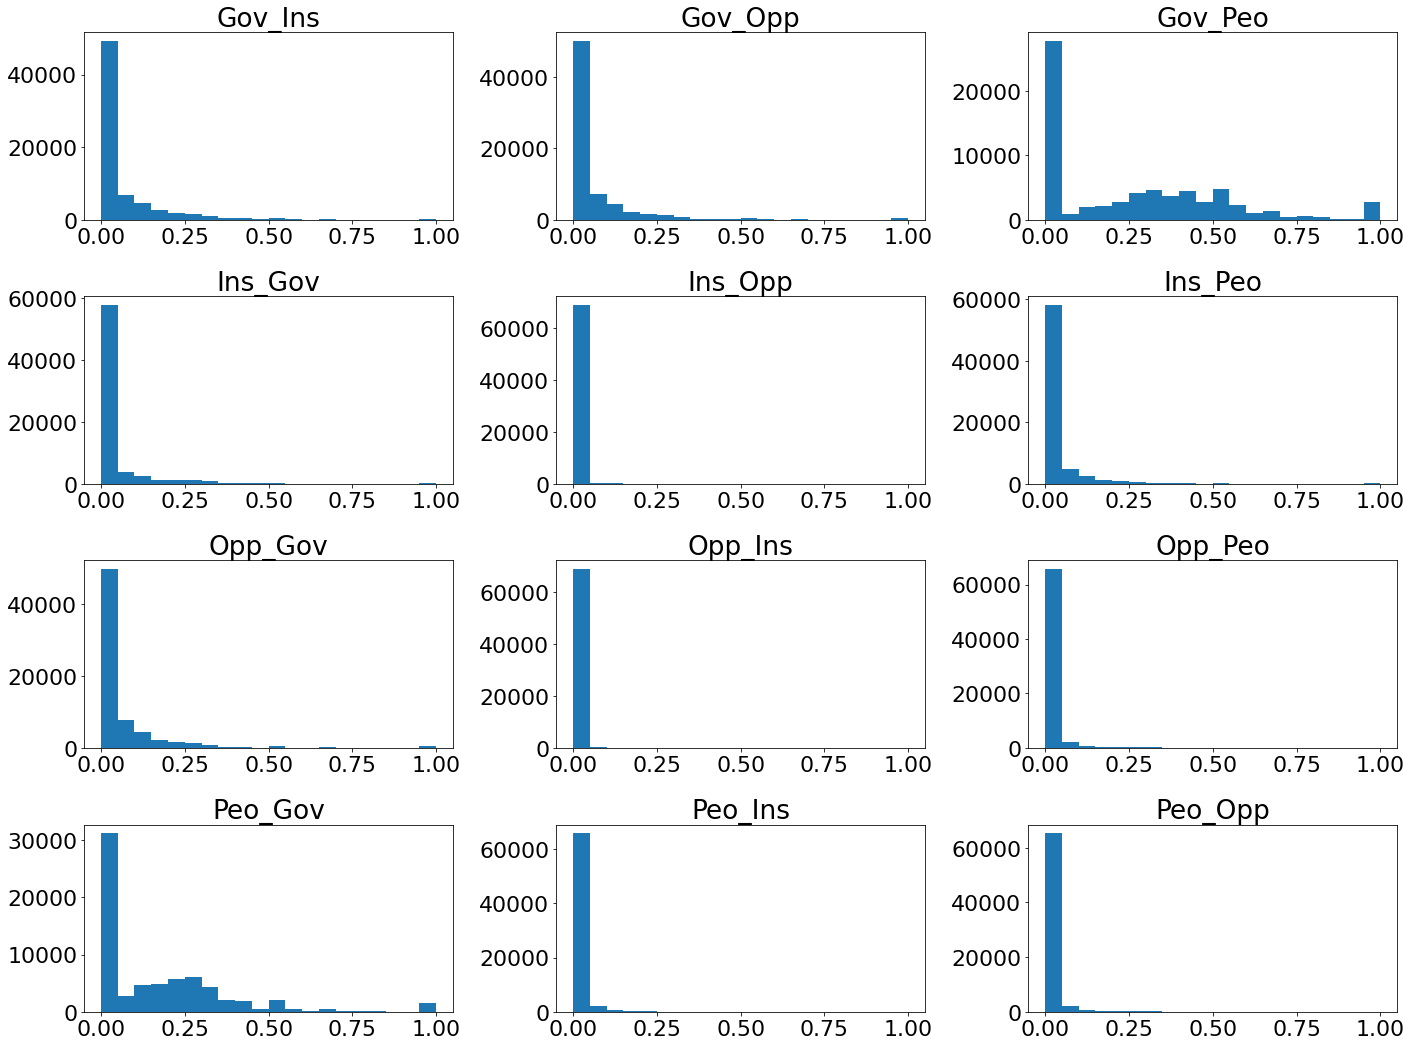

In [16]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,15))
cols_loop = [["Gov_Ins", "Gov_Opp", "Gov_Peo"], ["Ins_Gov", "Ins_Opp", "Ins_Peo"], 
           ["Opp_Gov", "Opp_Ins", "Opp_Peo"], ["Peo_Gov", "Peo_Ins", "Peo_Opp"]]
for i in range(0, 4):
    for j in range(0,3):
        axes[i,j].hist(interaction_fraction[cols_loop[i][j]], bins = 20)
        axes[i,j].set_title(cols_loop[i][j])
fig.tight_layout()

Most of the plots are very left skewed, while others present bimodal distributions. This is due to monthly aggregations where no events were registered at all, since they are filled with 0s. The purpose is to deetermine conflict from events so, to improve the model, entries where the sum of the predictors is 0 (it should be 1, since they represent a fraction) will be removed:

In [17]:
cols = ["Gov_Ins", "Gov_Opp", "Gov_Peo", "Ins_Gov", "Ins_Opp", "Ins_Peo", 
           "Opp_Gov", "Opp_Ins", "Opp_Peo", "Peo_Gov", "Peo_Ins", "Peo_Opp"]
model_filtered = interaction_fraction[(interaction_fraction[cols].sum(axis=1) != 0)]

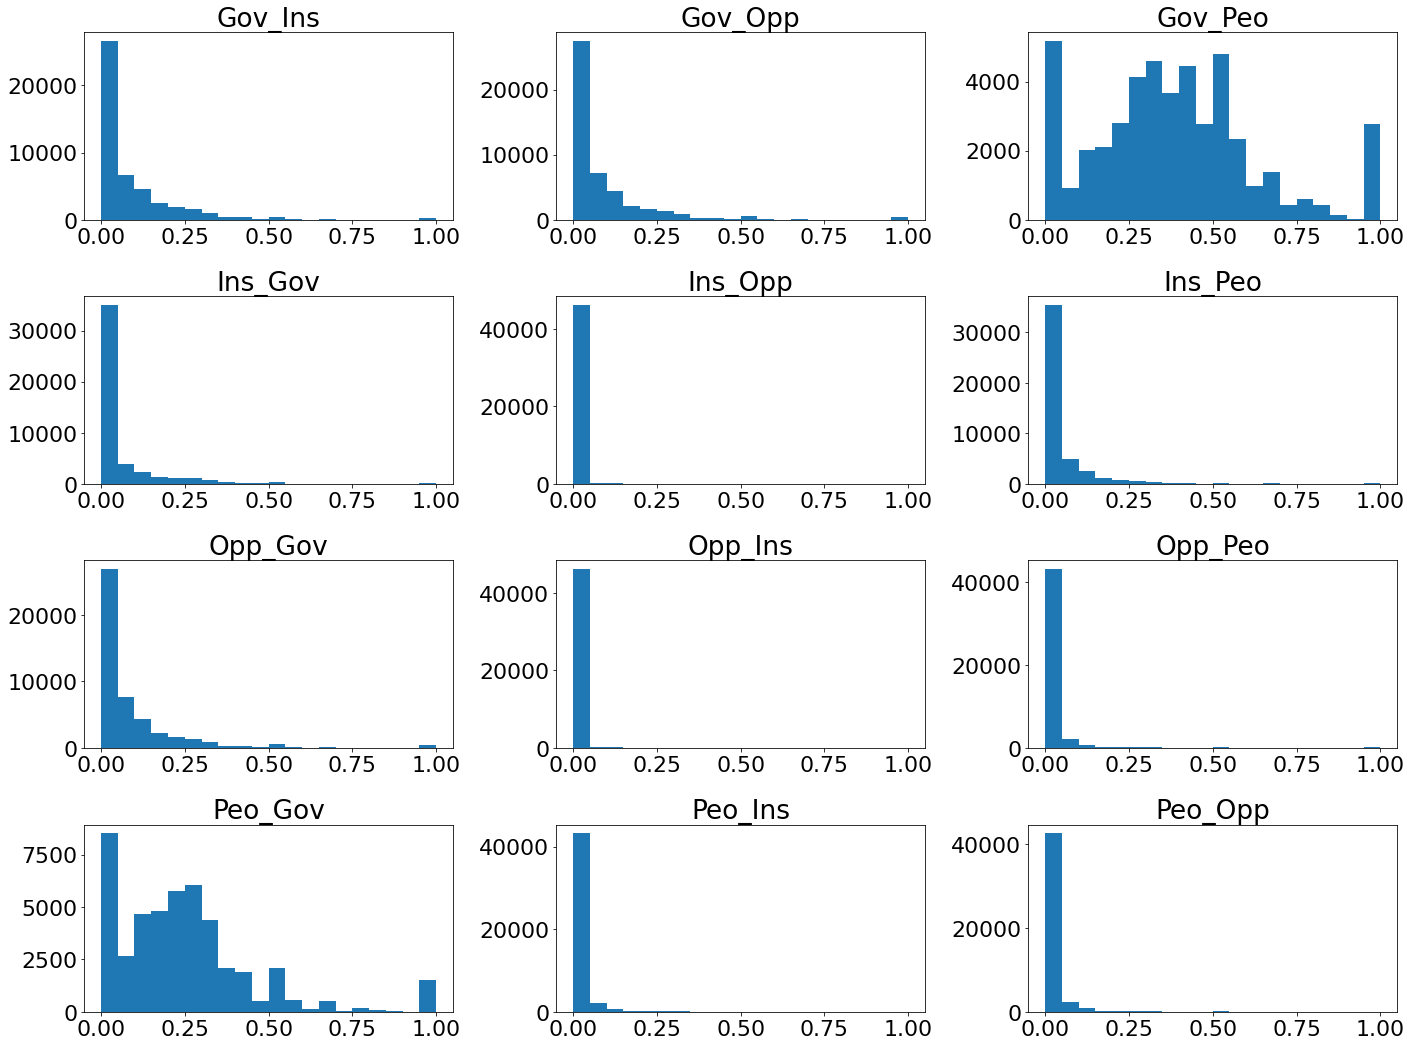

In [18]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,15))
for i in range(0, 4):
    for j in range(0,3):
        axes[i,j].hist(model_filtered[cols_loop[i][j]], bins = 20)
        axes[i,j].set_title(cols_loop[i][j])
fig.tight_layout()

Interactions between People and Goverment are more frequent than interactions with other sectors. This columns (*"Gov_Peo"* and *"Peo_Gov"*) have a bimodal distribution, with maximums around 0 and 0.25. The rest of the columns look more like exponential functions, with most of the values very close to 0. 

### 2.1.1. Differences between cases
We want to compare cases where a civil war starts where case where it does not, and cases where a civil war ends with cases were it continues. 

In [19]:
no_civil_war = model_filtered[model_filtered["CW_plus1"]=="000"]
civil_war_starts = model_filtered[model_filtered["CW_plus1"]=="100"]
civil_war_finishes = model_filtered[model_filtered["CW_plus1"]=="010"]
civil_war_ongoing = model_filtered[model_filtered["CW_plus1"]=="001"]

As a first approach we can take a look at the means of each column:

In [20]:
cols = ["Gov_Ins", "Gov_Opp", "Gov_Peo", "Ins_Gov", "Ins_Opp", "Ins_Peo", 
           "Opp_Gov", "Opp_Ins", "Opp_Peo", "Peo_Gov", "Peo_Ins", "Peo_Opp"]
mean_values = pd.DataFrame(index = ["000", "100", "010", "001"], columns = cols)
mean_values.loc["000",:] = no_civil_war[cols].mean().round(4)
mean_values.loc["100",:] = civil_war_starts[cols].mean().round(4)
mean_values.loc["010",:] = civil_war_finishes[cols].mean().round(4)
mean_values.loc["001",:] = civil_war_ongoing[cols].mean().round(4)
mean_values

,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
000,0.0655,0.0803,0.406,0.0308,0.0014,0.0311,0.0813,0.0014,0.0158,0.2577,0.0117,0.017
100,0.0795,0.1139,0.3414,0.0751,0.0013,0.0269,0.097,0.0065,0.0228,0.2134,0.0068,0.0155
010,0.1672,0.0742,0.2204,0.1204,0.0032,0.0774,0.0617,0.0024,0.0092,0.2252,0.0202,0.0185
001,0.1607,0.0542,0.2621,0.1471,0.0037,0.0948,0.0575,0.0032,0.0099,0.1727,0.024,0.01


Some slightly differences can be seen between the means for each case, however, that does not mean that they are statistically significant. 

In [21]:
pvalues_snw = []
for i in range(0, len(cols)):
    a = no_civil_war[cols[i]]
    b = civil_war_starts[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_snw.append((cols[i], pvalue))
pd.DataFrame(pvalues_snw).set_index(0).sort_values(1).transpose()

,Ins_Gov,Peo_Gov,Gov_Peo,Peo_Ins,Gov_Opp,Opp_Ins,Gov_Ins,Opp_Gov,Opp_Peo,Ins_Peo,Peo_Opp,Ins_Opp
1,0.08139,0.106913,0.107398,0.127057,0.280774,0.362587,0.409302,0.457827,0.475894,0.692849,0.768846,0.807861


We see that the smallest p-value is for the column that represents when Insurgents are the source and Government is the target. For that columns the means were:

In [22]:
mean_values.loc[["000","100"],["Ins_Gov"]].transpose()

,000,100
Ins_Gov,0.0308,0.0751


So the number of events where Insurgents are the source and Government is the target increase when a civil war is about to start. Although, this differences are not statistically significant, it is good to ask how do they increase? Is it because they become allies or because they become enemies? The logic suggest the latter, however this model does not provide enough information to support this. 

Doing the same for ongoingness and ending of a civil war:

In [23]:
pvalues_of = []
for i in range(0, len(cols)):
    a = civil_war_finishes[cols[i]]
    b = civil_war_ongoing[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_of.append((cols[i], pvalue))
pd.DataFrame(pvalues_of).set_index(0).sort_values(1).transpose()

,Peo_Gov,Gov_Peo,Ins_Gov,Ins_Peo,Peo_Ins,Peo_Opp,Gov_Opp,Opp_Ins,Ins_Opp,Opp_Gov,Gov_Ins,Opp_Peo
1,0.129243,0.157433,0.203523,0.343126,0.353074,0.388165,0.409561,0.513938,0.76336,0.802144,0.841175,0.857689


This time all p-values are above 0.1, so the differences between the means are not statistically significant, with the lowest p-value being for actions taken by the Government that targeted People. 

However, this does not mean this model is not good for the purposes of this project. 

### 2.1.2. Principal component analysis 
Principal component analysis is used to collect information about the model a provide a simple visualization using its fisrt two components. 

In [24]:
cols = ["Gov_Ins", "Gov_Opp", "Gov_Peo", "Ins_Gov", "Ins_Opp", "Ins_Peo", 
           "Opp_Gov", "Opp_Ins", "Opp_Peo", "Peo_Gov", "Peo_Ins", "Peo_Opp"]
data = model_filtered[cols]

# Standardize
ss = StandardScaler()
data = ss.fit_transform(data)

In [25]:
pca = PCA(2)
pca.fit(data)

PCA(n_components=2)

In [26]:
pca.explained_variance_ratio_

array([0.15244824, 0.1259631 ])

The first two components explain about 24% of the variation of the data. Each predictor should explain about 8% of the variation of the data (there are 12 predictors so 100/12~8), so the first two principal components explain results slightly better than the original model. 

Visualising the data using those two components the following plot is generated:

In [27]:
data_transformed = pca.transform(data)

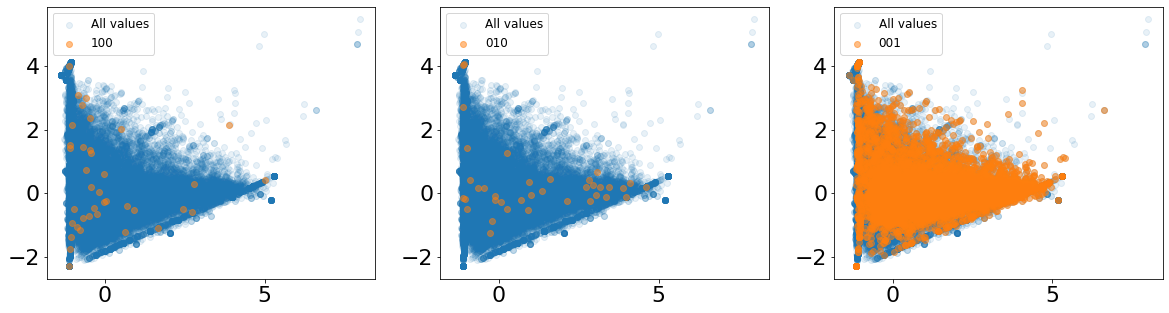

In [28]:
f, ax = plt.subplots(ncols = 3, figsize = (20,5))
ax[0].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[0].scatter(data_transformed[model_filtered["CW_plus1"]=="100",0], 
            data_transformed[model_filtered["CW_plus1"]=="100",1], alpha = 0.5)
ax[0].legend(["All values", "100"], prop={'size': 12})
ax[1].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[1].scatter(data_transformed[model_filtered["CW_plus1"]=="010",0], 
            data_transformed[model_filtered["CW_plus1"]=="010",1], alpha = 0.5)
ax[1].legend(["All values", "010"], prop={'size': 12})
ax[2].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[2].scatter(data_transformed[model_filtered["CW_plus1"]=="001",0], 
            data_transformed[model_filtered["CW_plus1"]=="001",1], alpha = 0.5)
ax[2].legend(["All values", "001"], prop={'size': 12})

The plot is fan-shaped. Starting civil wars are distributed more vertically, suggesting that the first principal component separates those values from the rest. Ending civil wars are distributed more horizontally, suggesting that the second component separates those cases best. Ongoing civil wars are evenly distributed throught the whole distribution. 

Therefore, it is useful to see how each of the predictors contribute to each component:

In [29]:
components = pd.DataFrame(pca.components_).transpose()
sorted_cols = components[0].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,0]) for i in sorted_cols][:3]

[('Ins_Gov', 0.5382158660533166),
 ('Gov_Ins', 0.5035860444546457),
 ('Ins_Peo', 0.40832507498936704)]

In [30]:
sorted_cols = components[1].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,1]) for i in sorted_cols][:3]

[('Gov_Peo', -0.638449664625462),
 ('Opp_Gov', 0.5145851396078149),
 ('Gov_Opp', 0.49252377053384033)]

The first component heavily relies on Insurgents and the interaction between them and Government. This is the same result obtained when evaluating the diferences between means in the previous section for starting civl wars, where this predictor had a relatively low p-value. 

The second component studies interactions between Government and Opposition and also actions taken by the Government to People. Simmilar to what was obtained for differences between means between ending and ongoingness of a civil war in the previous section. 

This suggests that, although p-values are very low, the *Interaction Fraction* model is able to detect certain key predictors for the purposes of this project. 

### 2.1.3. Training the model
Random forests are good at handling noisy data and outliers. However, monthly aggregations with no events at all will be removed for training purposes. The data will be splitted in training and testig sets at the beginning of 2004. Rows without events will be removed too:

In [31]:
date_filter = "2004-01"

Xtrain = interaction_fraction[interaction_fraction["Year_Month"]>=date_filter][cols]
ytrain = interaction_fraction[interaction_fraction["Year_Month"]>=date_filter].iloc[:,-1]

Xtest = interaction_fraction[interaction_fraction["Year_Month"]<date_filter][cols]
ytest = interaction_fraction[interaction_fraction["Year_Month"]<date_filter].iloc[:,-1]

In [32]:
# Removing empty data
indexes = (Xtrain.sum(axis=1) != 0)
Xtrain_cleaned = Xtrain.loc[indexes,:]
ytrain_cleaned = ytrain.loc[indexes]

10000 trees will be used to better handle noise and each tree of the forest is set to have no more than 4 leaf nodes to reduce the size of the tree, preventing overfitting in each weak learner. 

In [33]:
rf1 = RandomForestClassifier(random_state = 1492, n_estimators = 10000, oob_score = True,
                               criterion = "entropy", max_leaf_nodes=4)
rf1.fit(Xtrain_cleaned, ytrain_cleaned)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=4,
                       n_estimators=10000, oob_score=True, random_state=1492)

In [34]:
ytrain_score = rf1.oob_decision_function_

In [35]:
classes = rf1.classes_
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytrain_cleaned==classes[i], ytrain_score[:,i]))

000 : 0.9119562735869504
001 : 0.9131226505354174
010 : 0.6778269785134775
100 : 0.6147045190204949


Due to the imbalance of the data (cases are almost always "000"), it is not surprising that the model works well for those classes (AUC score over 0.9). The model also works well at predicting ongoingness of the conflict ("001"), with a high AUC score (over 0.9). For ending civil wars ("010") the AUC score is also relatively high, being better that a random classifier (with an AUC of 0.5). The same case applies when predicting starting civil wars ("100"). 

In [36]:
ypred = rf1.predict_proba(Xtest)

In [37]:
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytest==classes[i], ypred[:,i]))

000 : 0.8687215145342613
001 : 0.8712529109847383
010 : 0.6978355368460802
100 : 0.5982664092664093


Testing set's results are very consistent with the out of bag predictions, suggesting that no overfitting or underfitting is happening. 

One last thing to do with this model is to check if the predictors that appeared with the t-tests and the PCA are relevant to our model:

In [38]:
importance = rf1.feature_importances_
importance_list = []

for i in range(0,len(cols)):
    importance_list.append((cols[i], importance[i]))

importance_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [39]:
importance_df.sort_values("Importance", ascending = False).transpose()

,3,5,10,0,4,2,7,9,6,8,1,11
Predictor,Ins_Gov,Ins_Peo,Peo_Ins,Gov_Ins,Ins_Opp,Gov_Peo,Opp_Ins,Peo_Gov,Opp_Gov,Opp_Peo,Gov_Opp,Peo_Opp
Importance,0.336304,0.182119,0.170992,0.114179,0.0725058,0.054836,0.0384296,0.0168433,0.00979442,0.0025303,0.0011806,0.000285607


As shown in the section where the t-tests were made, and in the principal component section, Insurgents play a key rol determining civil wars, with predictors that have them as sector beint the ones with higher importance. 

## 2.2. Mean intensity model
One of the problems with the previous model was that there was no way to see if the interaction was positive or negative. If more interaction meant cooperation or attacks. This model aims to solve those problems. 

This model uses the *"Intensity"* column from the ICEWS datasets and returns the mean value for each month and for each interaction type. For example, looking at data from 2017:

In [40]:
year_2017_iso3.drop(["Country"], axis = 1)
year_2017_iso3.head(1)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
2,Burundi,BDI,2017-01,193,-10.0,0,0,0,1,0,0,0,0,0,0,0,0


This is just one event, now its intensity will be stored in the interaction column:

In [41]:
mean_intensity_2017 = year_2017_iso3.loc[:,["ISO3","Year_Month"]]
for col in cols:
    mean_intensity_2017.loc[:,col] = year_2017_iso3.loc[:,col]*year_2017_iso3.loc[:,"Intensity"]
mean_intensity_2017.head(1)    

,ISO3,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
2,BDI,2017-01,-0.0,-0.0,-0.0,-10.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0


Then results are averaged for each month: 

In [42]:
mean_intensity_2017.groupby(["ISO3","Year_Month"]).mean().loc["BDI","2017-01",:]

,,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
ISO3,Year_Month,,,,,,,,,,,,
BDI,2017-01,0.0,0.0,-0.794595,-3.648649,0.0,-0.513514,0.081081,0.0,0.0,-0.432432,0.0,0.0


The model is generated using the <code>mean_intensity</code> function, but data has already been saved as a *.csv* file.

In [43]:
mean_intensity = pd.read_csv("mean_intensity_model.csv", converters = {"CW_plus1" : str})
mean_intensity = mean_intensity.drop("Unnamed: 0", axis = 1)
mean_intensity["Year_Month"] = pd.to_datetime(mean_intensity["Year_Month"]).dt.to_period('M')

In [44]:
mean_intensity.sample(5)

,ISO3,Year_Month,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,...,Peo_Gov,Peo_Ins,Peo_Opp,CW_s,CW_f,CW_o,CW_s_plus1,CW_f_plus1,CW_o_plus1,CW_plus1
12199,COG,2003-08,1.166667,-0.333333,-2.333333,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,000
13093,COM,2006-02,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.00,-2.0,0.00,0.0,0.0,0.0,0,0,0,000
66992,VUT,2009-09,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,000
48849,PER,2009-10,-0.080000,0.000000,-1.080000,-1.2,0.0,-0.36,0.0,0.0,...,-0.58,0.0,-0.16,0.0,0.0,0.0,0,0,0,000
49368,PLW,2005-01,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.0,0.0,0,0,0,000


The distributions of each column values are plotted bellow:

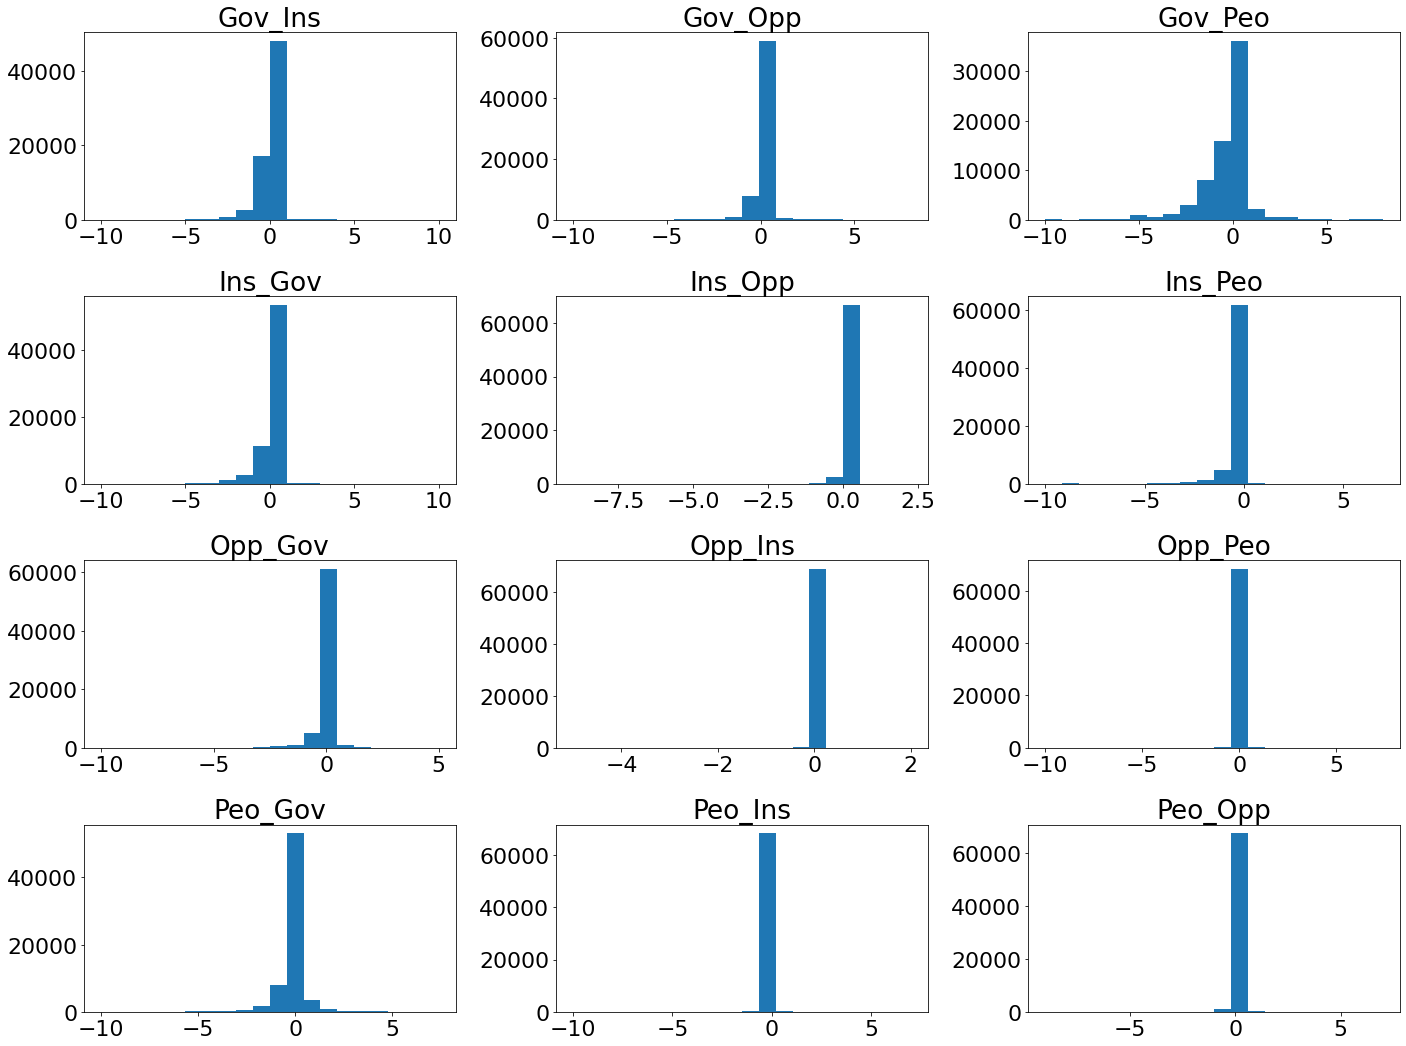

In [45]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,15))
for i in range(0, 4):
    for j in range(0,3):
        axes[i,j].hist(mean_intensity[cols_loop[i][j]], bins = 20)
        axes[i,j].set_title(cols_loop[i][j])
fig.tight_layout()

This time distributions are centered around 0 and values lie at both sides of the peak. However this peak is too big and it has to do with how missing data is handled in the model, filled with 0s. Again, as in the previous model, this is because monthly aggregations without registered events. Those rows need to be removed:

In [46]:
model_filtered = mean_intensity[(interaction_fraction[cols].sum(axis=1) != 0)]

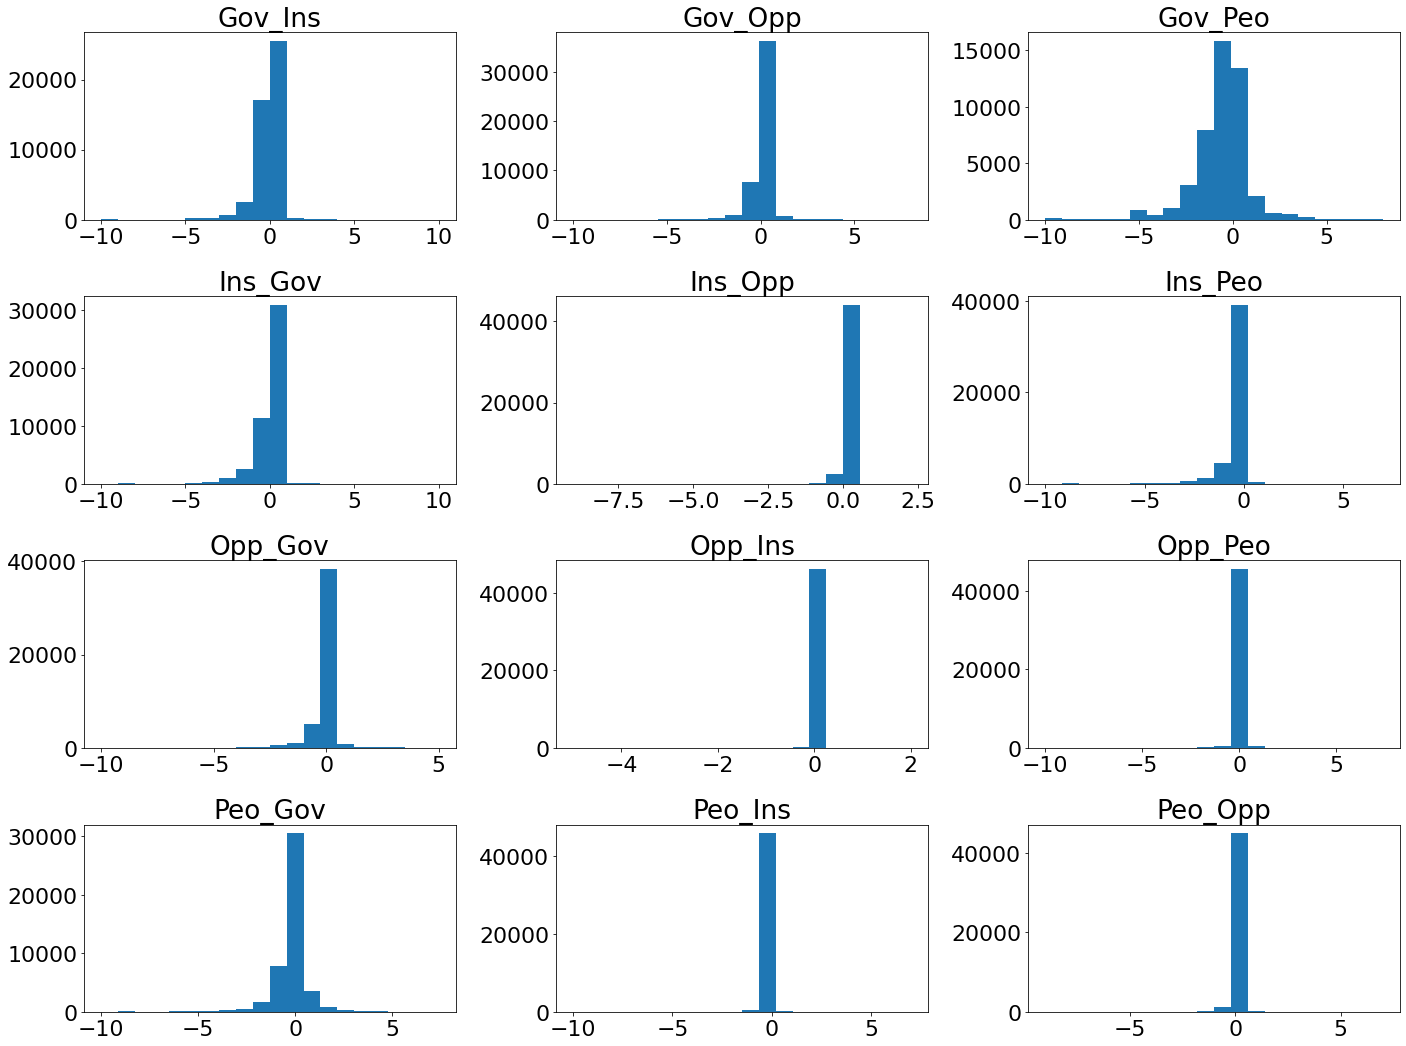

In [47]:
fig, axes = plt.subplots(ncols = 3, nrows = 4, figsize = (20,15))
for i in range(0, 4):
    for j in range(0,3):
        axes[i,j].hist(model_filtered[cols_loop[i][j]], bins = 20)
        axes[i,j].set_title(cols_loop[i][j])
fig.tight_layout()

These distributions represent the mean intensity between each sector. Intensity of interactions between People and Government (*"Gov_Peo"* and *"Peo_Gov"*) seem to follow a normal distribution, while the rest of the distributions are right-skewed, suggesting that the mean intensity of the interactions between those groups tends to be negative. 

### 2.2.1. Differences between cases
As in the previous model, understanding statistically significant differences between cases can lead to a better understanding of the circumstances under which a civil war starts, finishes or continues. 

In [48]:
no_civil_war = model_filtered[model_filtered["CW_plus1"]=="000"]
civil_war_starts = model_filtered[model_filtered["CW_plus1"]=="100"]
civil_war_finishes = model_filtered[model_filtered["CW_plus1"]=="010"]
civil_war_ongoing = model_filtered[model_filtered["CW_plus1"]=="001"]

In [49]:
cols = ["Gov_Ins", "Gov_Opp", "Gov_Peo", "Ins_Gov", "Ins_Opp", "Ins_Peo", 
           "Opp_Gov", "Opp_Ins", "Opp_Peo", "Peo_Gov", "Peo_Ins", "Peo_Opp"]
mean_values = pd.DataFrame(index = ["000", "100", "010", "001"], columns = cols)
mean_values.loc["000",:] = no_civil_war[cols].mean().round(4)
mean_values.loc["100",:] = civil_war_starts[cols].mean().round(4)
mean_values.loc["010",:] = civil_war_finishes[cols].mean().round(4)
mean_values.loc["001",:] = civil_war_ongoing[cols].mean().round(4)
mean_values

,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
000,-0.1852,-0.0566,-0.62,-0.1437,-0.0063,-0.2377,-0.1073,-0.0016,-0.0054,-0.1626,-0.0293,-0.0103
100,-0.2678,-0.143,-0.6706,-0.2873,-0.0015,-0.2246,-0.1982,-0.0003,-0.0316,-0.3738,-0.0088,0.005
010,-0.4828,-0.2573,-0.6727,-0.6201,-0.0053,-0.6689,-0.1689,-0.0052,-0.0089,-0.1656,-0.046,0.0046
001,-0.5791,-0.0621,-0.6059,-0.8051,-0.0168,-0.7423,-0.1032,-0.0024,-0.0086,-0.249,-0.0618,-0.0115


Differences between means are observed, however, that does not mean that they are statistically significant. It is also worth noticing that all means are negative. To determine the statistical significance, t-tests will be performed.

Statistically significant differences between cases without a civil war a cases where a civil war starts:

In [50]:
pvalues_snw = []
for i in range(0, len(cols)):
    a = no_civil_war[cols[i]]
    b = civil_war_starts[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_snw.append((cols[i], pvalue))
pd.DataFrame(pvalues_snw).set_index(0).sort_values(1).transpose()

,Peo_Ins,Peo_Gov,Ins_Opp,Ins_Gov,Gov_Opp,Opp_Gov,Opp_Ins,Peo_Opp,Opp_Peo,Gov_Ins,Gov_Peo,Ins_Peo
1,0.000072,0.088081,0.192253,0.257627,0.312214,0.32632,0.327638,0.343225,0.405393,0.416823,0.82117,0.89206


One predictor has a p-value bellow 0.05 and that is *"Peo_Ins"*, refering to actions taken by People towards Insurgents. The means for that column were:

In [51]:
mean_values.loc[["000","100"],["Ins_Peo", "Peo_Gov"]].transpose()

,000,100
Ins_Peo,-0.2377,-0.2246
Peo_Gov,-0.1626,-0.3738


So it looks like when a civil war starts the mean intensity decreases. This could mean that insurgents stop their focus on the People and go for other sectors. However, the data does not provide that information.

The second lowest p-value is above the 0.05 threshold selected to define statistical significance, however this differences imply the intensity of this interaction doubles when a civil war starts. The negative value suggest that negative actions taken by people against government increase. This could be a dicrease on People's opinion about the Government, protests, mobs or even fighting. The current data does not provide enough information on that. 

For ongoingness and ending of civil wars, the p-values for each column are:

In [52]:
pvalues_of = []
for i in range(0, len(cols)):
    a = civil_war_finishes[cols[i]]
    b = civil_war_ongoing[cols[i]]
    pvalue = sp.ttest_ind(a, b, equal_var=False).pvalue
    pvalues_of.append((cols[i], pvalue))
pd.DataFrame(pvalues_of).set_index(0).sort_values(1).transpose()

,Ins_Opp,Ins_Gov,Gov_Opp,Peo_Opp,Peo_Ins,Peo_Gov,Gov_Ins,Opp_Gov,Ins_Peo,Gov_Peo,Opp_Ins,Opp_Peo
1,0.039651,0.237241,0.245944,0.291567,0.36237,0.382831,0.579609,0.595491,0.648892,0.66141,0.777902,0.971989


One p-value is bellow 0.05 for *"Ins_Opp"*. The means for each case are:

In [53]:
mean_values.loc[["010","001"],["Ins_Opp"]].transpose()

,010,001
Ins_Opp,-0.0053,-0.0168


The intensity doubles, suggesting a relaxation at the ending of a civil war actions from Insurgents to Opposition. Once again, the data used in this model does not specify if this is because an increase in cooperation or a decrease in attacks. 

### 2.2.2. Principal component analysis
To see if the model is able to split the data, principal component analysis will be performed:

In [54]:
data = model_filtered[cols]

# Standardize
ss = StandardScaler()
data = ss.fit_transform(data)

In [55]:
pca = PCA(2)
pca.fit(data)

PCA(n_components=2)

In [56]:
pca.explained_variance_ratio_

array([0.12039647, 0.11205852])

This time the two first principal components explain slightly less variance than the previous model, only a 23%. Again, having 12 predictors this means that this two principal components "behave" like three predictors (100/12~8). Although this it not much, these two principal components will allow model visualization:

In [57]:
data_transformed = pca.transform(data)

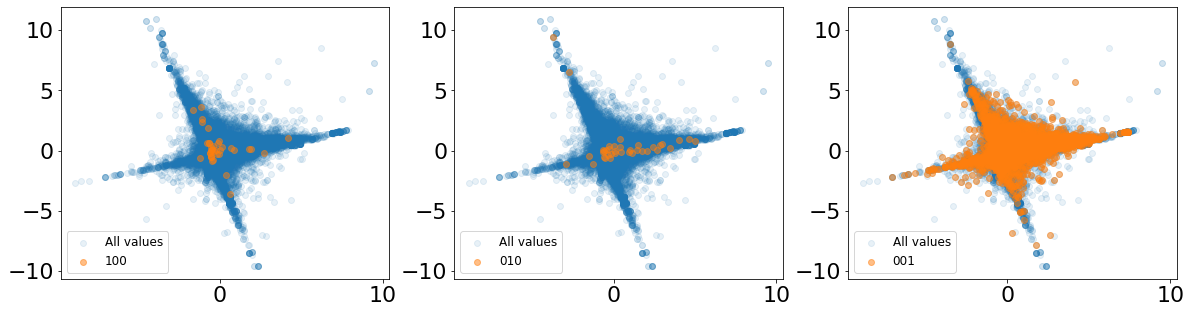

In [58]:
f, ax = plt.subplots(ncols = 3, figsize = (20,5))
ax[0].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[0].scatter(data_transformed[model_filtered["CW_plus1"]=="100",0], 
            data_transformed[model_filtered["CW_plus1"]=="100",1], alpha = 0.5)
ax[0].legend(["All values", "100"], prop={'size': 12})
ax[1].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[1].scatter(data_transformed[model_filtered["CW_plus1"]=="010",0], 
            data_transformed[model_filtered["CW_plus1"]=="010",1], alpha = 0.5)
ax[1].legend(["All values", "010"], prop={'size': 12})
ax[2].scatter(data_transformed[:,0], data_transformed[:,1], alpha = 0.1)
ax[2].scatter(data_transformed[model_filtered["CW_plus1"]=="001",0], 
            data_transformed[model_filtered["CW_plus1"]=="001",1], alpha = 0.5)
ax[2].legend(["All values", "001"], prop={'size': 12})

The distribution looks like a 4-point star. The arms of the star closely follow each one of the first two principals component. Most of the values for starting and ending civil wars are centered around (0,0). 

Starting civil wars tend to be across the quasi-vertical arms of the 4-point star. This suggest that the first principal component separates those values from the others. 

Ending civil wars tend to be across the quasi-horizontal arms of the 4-point star. This suggest that the second principal component is able to split the data separating those values. 

For ongoing civil wars, values are spreaded throughout the distribution. 

The predictors that contribute the most to each component are:

In [59]:
components = pd.DataFrame(pca.components_).transpose()
sorted_cols = components[0].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,0]) for i in sorted_cols][:3]

[('Ins_Gov', -0.6126984938890976),
 ('Gov_Ins', -0.5406556499834322),
 ('Ins_Peo', -0.4393745424506452)]

Insurgents have the most influence in the first component, with this component being able to separate values for starting civil wars. This is the same that was observed in the previous model. 

For the second component:

In [60]:
sorted_cols = components[1].abs().sort_values(ascending = False).index
[(cols[i], components.iloc[i,1]) for i in sorted_cols][:3]

[('Gov_Opp', -0.6258130287074675),
 ('Opp_Gov', -0.6191662676708626),
 ('Peo_Gov', -0.2791671396604188)]

This time, as in the previous model, Opposition is the relevant sector to look at for the second component, being this one the one that separates ending civil wars from the rest. 

### 2.2.3. Training the model

In [61]:
date_filter = "2004-01"

Xtrain = mean_intensity[mean_intensity["Year_Month"]>=date_filter][cols]
ytrain = mean_intensity[mean_intensity["Year_Month"]>=date_filter].iloc[:,-1]

Xtest = mean_intensity[mean_intensity["Year_Month"]<date_filter][cols]
ytest = mean_intensity[mean_intensity["Year_Month"]<date_filter].iloc[:,-1]

In [62]:
# Removing empty data
indexes = (Xtrain.sum(axis=1) != 0)
Xtrain_cleaned = Xtrain.loc[indexes,:]
ytrain_cleaned = ytrain.loc[indexes]

In [63]:
rf2 = RandomForestClassifier(random_state = 1492, n_estimators = 10000, oob_score = True,
                               criterion = "entropy", max_leaf_nodes=4)
rf2.fit(Xtrain_cleaned, ytrain_cleaned)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=4,
                       n_estimators=10000, oob_score=True, random_state=1492)

In [64]:
ytrain_score = rf2.oob_decision_function_

In [65]:
classes = rf2.classes_
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytrain_cleaned==classes[i], ytrain_score[:,i]))

000 : 0.8960071567413784
001 : 0.897081974369413
010 : 0.6839505722825692
100 : 0.5396734043728236


In [66]:
ypred = rf2.predict_proba(Xtest)

In [67]:
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytest==classes[i], ypred[:,i]))

000 : 0.8612388304827352
001 : 0.8627088932694839
010 : 0.7102584568115793
100 : 0.6215009652509652


The results are very similar to the ones obtained in the previous model, although slightly worse, with an AUC of 0.54 for the out of bag samples of "100" that is only slightly better than a random predictor (with an AUC of 0.5). This suggests that the "Mean Intenstiy" model performs slightly worse than the "Interaction Fraction" model. 

Predictor importance in this case is:

In [68]:
importance = rf2.feature_importances_
importance_list = []

for i in range(0,len(cols)):
    importance_list.append((cols[i], importance[i]))

importance_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [69]:
importance_df.sort_values("Importance", ascending = False).transpose()

,3,5,10,0,4,9,7,6,1,2,11,8
Predictor,Ins_Gov,Ins_Peo,Peo_Ins,Gov_Ins,Ins_Opp,Peo_Gov,Opp_Ins,Opp_Gov,Gov_Opp,Gov_Peo,Peo_Opp,Opp_Peo
Importance,0.359915,0.212291,0.174873,0.119284,0.0659452,0.0331331,0.0142176,0.0136739,0.00427921,0.00208266,0.00015856,0.000145974


The first 5 most important predictors are exactly the same (with different importance) as in the previous model, suggesting, again, that Insurgents' behaviour is key in determining internal conflict. 

## 2.3. Combining both models
Combining both model can improve the model. That way both the fraction of the total interaction and the intensity of it will be considered. For that, both model will be merged and the random forest will be trained using that data:

In [70]:
mixed_model1 = interaction_fraction.iloc[:,:-7].merge(mean_intensity, on = ["ISO3", "Year_Month"], 
                           suffixes=('_if', '_mi'))
mixed_model1.sample(5)

,ISO3,Year_Month,Gov_Ins_if,Gov_Opp_if,Gov_Peo_if,Ins_Gov_if,Ins_Opp_if,Ins_Peo_if,Opp_Gov_if,Opp_Ins_if,...,Peo_Gov_mi,Peo_Ins_mi,Peo_Opp_mi,CW_s,CW_f,CW_o,CW_s_plus1,CW_f_plus1,CW_o_plus1,CW_plus1
10821,CHL,2008-10,0.100000,0.075000,0.450000,0.025000,0.0,0.000000,0.000000,0.0,...,-0.050000,0.175000,0.000000,0.0,0.0,0.0,0,0,0,000
21642,GEO,1998-07,0.102041,0.000000,0.285714,0.163265,0.0,0.102041,0.000000,0.0,...,-0.163265,-0.102041,0.000000,0.0,0.0,0.0,0,0,0,000
55964,SOM,2002-09,0.206897,0.000000,0.482759,0.103448,0.0,0.068966,0.034483,0.0,...,-0.310345,-0.310345,0.000000,0.0,0.0,1.0,0,0,1,001
28006,IMN,2000-11,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0,0,0,000
49876,POL,1999-05,0.000000,0.092308,0.461538,0.000000,0.0,0.015385,0.015385,0.0,...,-0.369231,0.000000,-0.092308,0.0,0.0,0.0,0,0,0,000


In [71]:
date_filter = "2004-01"

Xtrain = mixed_model1[mixed_model1["Year_Month"]>=date_filter].iloc[:,2:-7]
ytrain = mixed_model1[mixed_model1["Year_Month"]>=date_filter].iloc[:,-1]

Xtest = mixed_model1[mixed_model1["Year_Month"]<date_filter].iloc[:,2:-7]
ytest = mixed_model1[mixed_model1["Year_Month"]<date_filter].iloc[:,-1]

In [72]:
# Removing empty data
indexes = Xtrain.sum(axis=1) != 0
Xtrain_cleaned = Xtrain.loc[indexes,:]
ytrain_cleaned = ytrain.loc[indexes]

The p-values obtained in the two previous sections are exactly the same, and the results from the PCA obtained for both models are very similar. To see how well the combined models work, the results from training and testing the random forests will be used:

In [73]:
rf3 = RandomForestClassifier(random_state = 1492, n_estimators = 10000, oob_score = True,
                               criterion = "entropy", max_leaf_nodes=4)
rf3.fit(Xtrain_cleaned, ytrain_cleaned)

RandomForestClassifier(criterion='entropy', max_leaf_nodes=4,
                       n_estimators=10000, oob_score=True, random_state=1492)

In [74]:
ytrain_score = rf3.oob_decision_function_

In [75]:
classes = rf3.classes_
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytrain_cleaned==classes[i], ytrain_score[:,i]))

000 : 0.9125227021155906
001 : 0.9136788985504002
010 : 0.6863430010347571
100 : 0.5926384862594043


In [76]:
ypred = rf3.predict_proba(Xtest)

In [77]:
for i in range(0,len(classes)):
    print(classes[i],':',roc_auc_score(ytest==classes[i], ypred[:,i]))

000 : 0.8710301343715579
001 : 0.8730151418841086
010 : 0.7013614433187291
100 : 0.6480077220077219


In [78]:
importance = rf3.feature_importances_
importance_list = []

for i in range(0,len(Xtrain.columns)):
    importance_list.append((Xtrain.columns[i], importance[i]))

importance3_df = pd.DataFrame(importance_list, columns = ["Predictor","Importance"])

In [79]:
pd.set_option('display.max_columns', None)
importance_df.sort_values("Importance", ascending = False).transpose()

,3,15,5,17,10,22,0,12,4,2,7,16,9,21,6,8,19,1,18,11,14,13,23,20
Predictor,Ins_Gov_if,Ins_Gov_mi,Ins_Peo_if,Ins_Peo_mi,Peo_Ins_if,Peo_Ins_mi,Gov_Ins_if,Gov_Ins_mi,Ins_Opp_if,Gov_Peo_if,Opp_Ins_if,Ins_Opp_mi,Peo_Gov_if,Peo_Gov_mi,Opp_Gov_if,Opp_Peo_if,Opp_Ins_mi,Gov_Opp_if,Opp_Gov_mi,Peo_Opp_if,Gov_Peo_mi,Gov_Opp_mi,Peo_Opp_mi,Opp_Peo_mi
Importance,0.217982,0.180865,0.10061,0.0988781,0.0963106,0.0762373,0.0608089,0.0429674,0.034772,0.0302416,0.0183915,0.0164261,0.00905282,0.00649027,0.00388931,0.00241866,0.00111827,0.00105742,0.000673355,0.000609592,0.000123321,6.78072e-05,8.23218e-06,0


The first 8 best predictors are: *"Ins_Gov"*, *"Ins_Peo"*, *"Peo_Ins"* and *"Gov_Ins"*, for both the "Interaction Fraction" and "Mean Intensity" models, with the "Interaction Fraction" model's predictors always having a higher importances. This reinforces what was shown in the two previous sections, that the "Interaction Fraction" model works better than the "Mean Intensity" model. 

## 2.4. CAMEO fraction
But, what kind actions where Insurgents are involved are relevant? Are negociations important? Or are the attacks more relevant? This model will use the CAMEO column from the original ICEWS dataset.  There are 20 main CAMEO codes , each one with their own sublevels of coding. For example: 02 is Appeal but 0212 is Appeal for military cooperation. This model will only use the first two digits of the code:

- 01: Make public statement
- 02: Appeal
- 03: Express intent to cooperate
- 04: Consult
- 05: Engage in material cooperation
- 07: Provide aid
- 08: Yield
- 09: Investigate
- 10: Demamnd
- 11: Disapprove
- 12: Reject
- 13: Threaten
- 14: Protest
- 15: Exhibit force posture
- 16: Reduce relations
- 17: Coerce
- 18: Assault
- 19: Fight
- 20: Use unconventional mass violence. 

This model aims to solve the problem in the previous model on what actions where more relevan when predicting conflict. As in the "Interaction Fraction", each column will represent the fraction of total interactions that fall into one of the 20 CAMEO codes above and between the specified sectors. For example: 

In [80]:
year_2017_iso3.drop(["Country"], axis = 1)
year_2017_iso3.head(1)

,Country,ISO3,Year_Month,CAMEO,Intensity,Gov_Ins,Gov_Opp,Gov_Peo,Ins_Gov,Ins_Opp,Ins_Peo,Opp_Gov,Opp_Ins,Opp_Peo,Peo_Gov,Peo_Ins,Peo_Opp
2,Burundi,BDI,2017-01,193,-10.0,0,0,0,1,0,0,0,0,0,0,0,0


The CAMEO code for this event is 193, which is *Fight with small arms and light weapons*. However, only the two first digits will be used to simplify the code: 19 (*Fight*). Then, it will be assigned to the column of the sectors that interacted in the event, in this case *"Ins_Gov"*. Finally, dummy variables will be created for each type of interaction and each CAMEO code. Then, the fraction for each column related to the total number of events will be evaluated as in the "Interaction Fraction" model. This model is generated with the <code>cameo_fraction</code> function. 

In [81]:
cameo_fraction = pd.read_csv("cameo_fraction_model.csv")
cameo_fraction.sample(5)

,Unnamed: 0,ISO3,Year_Month,Gov_Ins_01,Gov_Ins_02,Gov_Ins_03,Gov_Ins_04,Gov_Ins_05,Gov_Ins_06,Gov_Ins_07,Gov_Ins_08,Gov_Ins_09,Gov_Ins_10,Gov_Ins_11,Gov_Ins_12,Gov_Ins_13,Gov_Ins_14,Gov_Ins_15,Gov_Ins_16,Gov_Ins_17,Gov_Ins_18,Gov_Ins_19,Gov_Ins_20,Gov_Opp_01,Gov_Opp_02,Gov_Opp_03,Gov_Opp_04,Gov_Opp_05,Gov_Opp_06,Gov_Opp_07,Gov_Opp_08,Gov_Opp_09,Gov_Opp_10,Gov_Opp_11,Gov_Opp_12,Gov_Opp_13,Gov_Opp_14,Gov_Opp_15,Gov_Opp_16,Gov_Opp_17,Gov_Opp_18,Gov_Opp_19,Gov_Opp_20,Gov_Peo_01,Gov_Peo_02,Gov_Peo_03,Gov_Peo_04,Gov_Peo_05,Gov_Peo_06,Gov_Peo_07,Gov_Peo_08,Gov_Peo_09,Gov_Peo_10,Gov_Peo_11,Gov_Peo_12,Gov_Peo_13,Gov_Peo_14,Gov_Peo_15,Gov_Peo_16,Gov_Peo_17,Gov_Peo_18,Gov_Peo_19,Gov_Peo_20,Ins_Gov_01,Ins_Gov_02,Ins_Gov_03,Ins_Gov_04,Ins_Gov_05,Ins_Gov_06,Ins_Gov_07,Ins_Gov_08,Ins_Gov_09,Ins_Gov_10,Ins_Gov_11,Ins_Gov_12,Ins_Gov_13,Ins_Gov_14,Ins_Gov_15,Ins_Gov_16,Ins_Gov_17,Ins_Gov_18,Ins_Gov_19,Ins_Gov_20,Ins_Opp_01,Ins_Opp_02,Ins_Opp_03,Ins_Opp_04,Ins_Opp_05,Ins_Opp_06,Ins_Opp_07,Ins_Opp_08,Ins_Opp_09,Ins_Opp_10,Ins_Opp_11,Ins_Opp_12,Ins_Opp_13,Ins_Opp_14,Ins_Opp_15,Ins_Opp_16,Ins_Opp_17,Ins_Opp_18,Ins_Opp_19,Ins_Opp_20,Ins_Peo_01,Ins_Peo_02,Ins_Peo_03,Ins_Peo_04,Ins_Peo_05,Ins_Peo_06,Ins_Peo_07,Ins_Peo_08,Ins_Peo_09,Ins_Peo_10,Ins_Peo_11,Ins_Peo_12,Ins_Peo_13,Ins_Peo_14,Ins_Peo_15,Ins_Peo_16,Ins_Peo_17,Ins_Peo_18,Ins_Peo_19,Ins_Peo_20,Opp_Gov_01,Opp_Gov_02,Opp_Gov_03,Opp_Gov_04,Opp_Gov_05,Opp_Gov_06,Opp_Gov_07,Opp_Gov_08,Opp_Gov_09,Opp_Gov_10,Opp_Gov_11,Opp_Gov_12,Opp_Gov_13,Opp_Gov_14,Opp_Gov_15,Opp_Gov_16,Opp_Gov_17,Opp_Gov_18,Opp_Gov_19,Opp_Gov_20,Opp_Ins_01,Opp_Ins_02,Opp_Ins_03,Opp_Ins_04,Opp_Ins_05,Opp_Ins_06,Opp_Ins_07,Opp_Ins_08,Opp_Ins_09,Opp_Ins_10,Opp_Ins_11,Opp_Ins_12,Opp_Ins_13,Opp_Ins_14,Opp_Ins_15,Opp_Ins_16,Opp_Ins_17,Opp_Ins_18,Opp_Ins_19,Opp_Ins_20,Opp_Peo_01,Opp_Peo_02,Opp_Peo_03,Opp_Peo_04,Opp_Peo_05,Opp_Peo_06,Opp_Peo_07,Opp_Peo_08,Opp_Peo_09,Opp_Peo_10,Opp_Peo_11,Opp_Peo_12,Opp_Peo_13,Opp_Peo_14,Opp_Peo_15,Opp_Peo_16,Opp_Peo_17,Opp_Peo_18,Opp_Peo_19,Opp_Peo_20,Peo_Gov_01,Peo_Gov_02,Peo_Gov_03,Peo_Gov_04,Peo_Gov_05,Peo_Gov_06,Peo_Gov_07,Peo_Gov_08,Peo_Gov_09,Peo_Gov_10,Peo_Gov_11,Peo_Gov_12,Peo_Gov_13,Peo_Gov_14,Peo_Gov_15,Peo_Gov_16,Peo_Gov_17,Peo_Gov_18,Peo_Gov_19,Peo_Gov_20,Peo_Ins_01,Peo_Ins_02,Peo_Ins_03,Peo_Ins_04,Peo_Ins_05,Peo_Ins_06,Peo_Ins_07,Peo_Ins_08,Peo_Ins_09,Peo_Ins_10,Peo_Ins_11,Peo_Ins_12,Peo_Ins_13,Peo_Ins_14,Peo_Ins_15,Peo_Ins_16,Peo_Ins_17,Peo_Ins_18,Peo_Ins_19,Peo_Ins_20,Peo_Opp_01,Peo_Opp_02,Peo_Opp_03,Peo_Opp_04,Peo_Opp_05,Peo_Opp_06,Peo_Opp_07,Peo_Opp_08,Peo_Opp_09,Peo_Opp_10,Peo_Opp_11,Peo_Opp_12,Peo_Opp_13,Peo_Opp_14,Peo_Opp_15,Peo_Opp_16,Peo_Opp_17,Peo_Opp_18,Peo_Opp_19,Peo_Opp_20,CW_s,CW_f,CW_o,CW_s_plus1,CW_f_plus1,CW_o_plus1,CW_plus1
44428,44428,NCL,2001-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
45939,45939,NIU,2007-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.

To clean rows where no events were registered, all rows where the sum of the columns is 0 will be removed. T